## convection skew to the mesh on a rectangle

$$
\mathbb{S}=
\begin{cases}
\Omega = [0, 1]\times[0,1] \\
u_{\text{D}}(x=0,y<y_{\text{in}}) = 0 \\
u_{\text{D}}(x=0,y \geq y_{\text{in}}) = u_{\text{in}} \\
u_{\text{D}}(x,y=0) = 0 \\
u_{\text{N}}(x,y=1)=u_{\text{D}}(x=1,y) = 0 ~\text{or}~ u_{\text{N}}(x,y=1)=u_{\text{N}}(x=1,y) = 0\\
\textbf{a}=a\cos\theta\textbf{e}_x + a\sin\theta\textbf{e}_y \\
\mathsf{D}=D\mathsf{I} \\
R=0 \\
J=0 \\
\end{cases}
$$

In [ ]:
import numpy as np
from lucifex.mesh import rectangle_mesh
from lucifex.fem import Function, Constant
from lucifex.solver import BoundaryValueProblem, bvp, BoundaryConditions
from lucifex.viz import plot_colormap
from lucifex.io import write, get_ipynb_file_name
from lucifex.utils import nested_dict
from lucifex.pde.advection_diffusion import steady_advection_diffusion
from lucifex.pde.supg import peclet


def create_solver(
    supg: str | None,
    Lx: float,
    Ly: float,
    Nx: int,
    Ny: int,
    u_inflow: float,
    y_inflow: float,
    bc_type: str,
    d: float, 
    a: float,
    theta: float,
) -> BoundaryValueProblem:
    mesh = rectangle_mesh(Lx, Ly, Nx, Ny)
    theta_rad = theta * np.pi / 180
    ax = a * np.cos(theta_rad)
    ay = a * np.sin(theta_rad)
    a = Constant(mesh, (ax, ay), name='a')
    d = Constant(mesh, d, name='d')
    u = Function((mesh, 'P', 1), name='u')
    bcs = BoundaryConditions(
        ('dirichlet', lambda x: x[1], 0.0),
        ('dirichlet', lambda x: np.isclose(x[0], 0) & (x[1] < y_inflow), 0.0),
        ('dirichlet', lambda x: np.isclose(x[0], 0) & (x[1] >= y_inflow), u_inflow),
        (bc_type, lambda x: x[0] - Lx, 0.0),
        (bc_type, lambda x: x[1] - Ly, 0.0),
    )
    u_solver = bvp(steady_advection_diffusion, bcs=bcs)(
        u, a, d, j=Constant(mesh, 0.0), supg=supg,
    )
    return u_solver


Lx = 1.0
Ly = 1.0
Nx = 20
Ny = 20
u_inflow = 1.0
y_inflow = 0.2
d = 1e-3
a = 1.0
theta = 30.0

hx = Lx / Nx
hy = Ly / Ny
Pe_x = peclet(hx, a, d)
Pe_y = peclet(hy, a, d)

supg_types = (None, 'coth', 'upwind')
bc_types = ('neumann', 'dirichlet')
solutions: dict[str | None, dict[str, Function]] = nested_dict(depth=2)
for supg in supg_types:
    for bc in bc_types:
        u_solver = create_solver(supg, Lx, Ly, Nx, Ny, u_inflow, y_inflow, bc, d, a, theta)
        u_solver.solve()
        solutions[supg][bc] = u_solver.solution

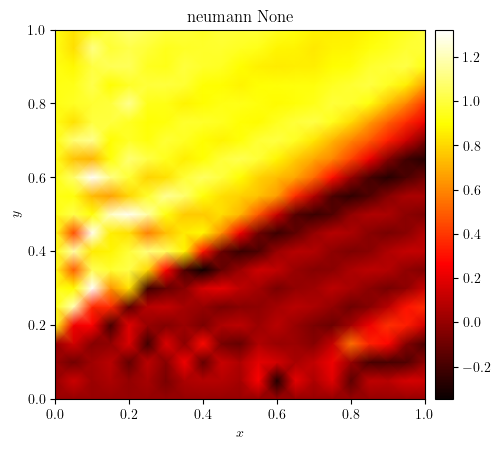

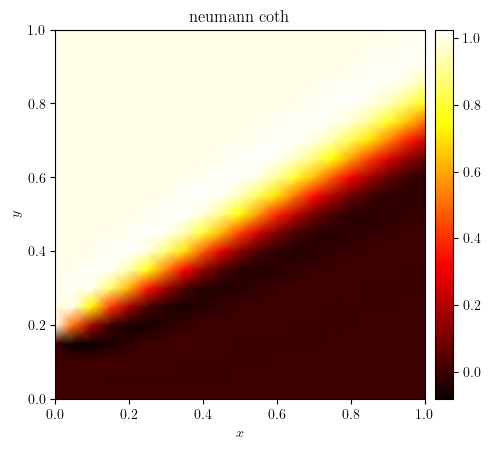

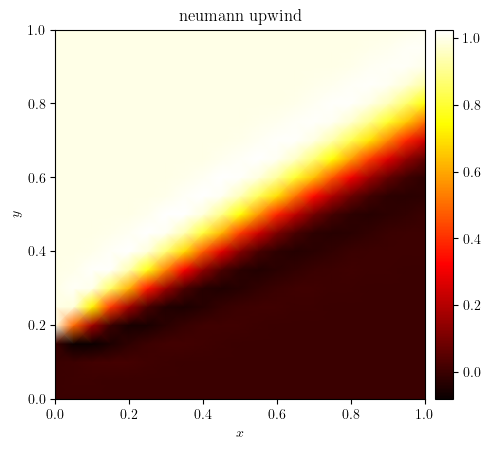

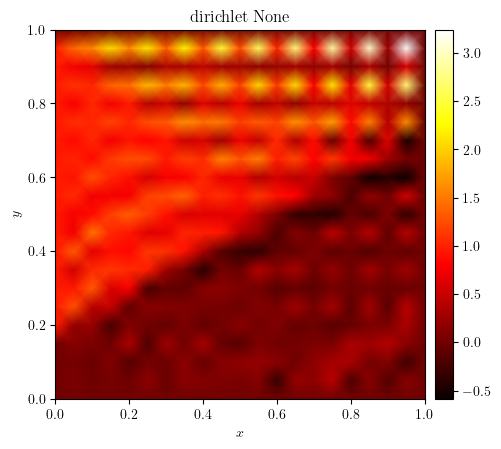

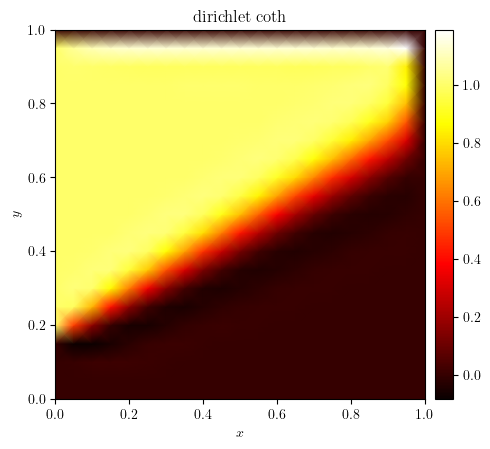

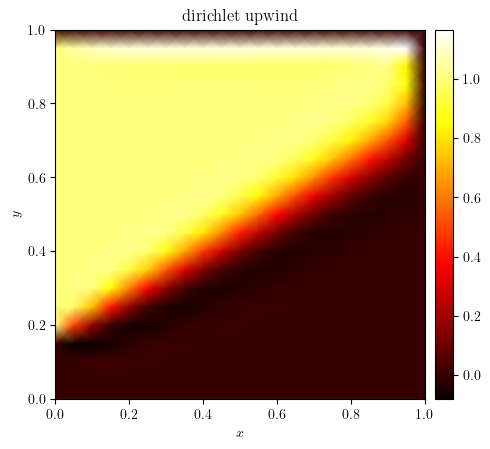

: 

In [ ]:
for bc in bc_types:
    for supg in supg_types:
        u = solutions[supg][bc]
        plot_colormap(u, title=f'{bc} {supg} ')